# Newton and Quasi-Newton Methods

Newton’s method is the basis of several iterative methods for optimization. Though
it converges quickly, it is often very computationally expensive. Variants on Newton’s method, including BFGS, remedy the problem somewhat by numerically approximating Hessian matrices. In
this lab we implement Newton’s method, BFGS, and the Gauss-Newton method for nonlinear least
squares problems.

## Exercise 1: Newton's Method

In [25]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.optimize import leastsq
import pandas as pd

In [7]:
def Newton(Df, Hf, x0, maxiter=500, tol=1e-8):
    iter = 0
    epsi = 1 
    D = Df(x0)
    H = Hf(x0)
    converged = False
    while (epsi > tol) & (iter < maxiter):
        iter +=1
        z = np.linalg.solve(H, D.T)
        x = x0 - z
        x0 = x
        D = Df(x0)
        H = Hf(x0)
        epsi = np.linalg.norm(D, np.inf)
    if  epsi< tol:
        converged = True
    
    return x, converged, iter

In [3]:
f = opt.rosen # The Rosenbrock function.
df = opt.rosen_der # The first derivative.
d2f = opt.rosen_hess # The second derivative (Hessian).
output = opt.fmin_bfgs(f=f, x0=[-2,2], fprime=df, maxiter=50, retall=True)



Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


In [4]:
Newton(df, d2f, [-2,2])

(array([1., 1.]), True, 5)

### Exercise 2: BFGS

In [10]:
def BFGS(Df, x0, maxiter=1000, tol=1e-8):
    iter = 0
    epsi = 1 
    D = Df(x0)
    A0 = np.eye(len(x0),len(x0))
    converged = False
    while (epsi > tol) & (iter < maxiter):
        iter +=1
        x = x0 - A0 @ D.T
        s = x - x0
        y = Df(x).T - D.T

        STY = s.T @ y
        if STY == 0:
            print("Dividing by zero!")
            break
        
        bloc1 = (STY + y.T @ A0 @ y) * np.outer(s,s.T) / ( STY )**2
        bloc2 = (A0 @  np.outer(y,s.T) + np.outer(s,y.T) @ A0)/ ( STY )
        A = A0 + bloc1 - bloc2
        A0 = A


        x0 = x
        D = Df(x0)

        
        epsi = np.linalg.norm(D, np.inf)

    
    if  epsi< tol:

        converged = True
    
    return x, converged, iter



In [11]:
BFGS(df,[-2,2])

(array([1., 1.]), True, 150)

### Exercise 3

Dividing by zero!
Dividing by zero!
Dividing by zero!
Dividing by zero!
Dividing by zero!


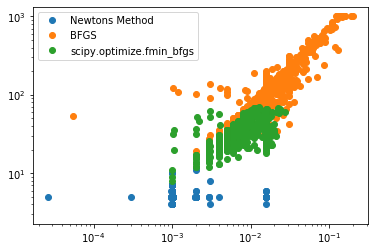

In [15]:
def comparison(N):
    x0 = np.random.uniform(low = -3, high = 3, size=(N,2))
    speed1 = []
    iter1 = []
    speed2 = []
    iter2 = []
    speed3 = []
    iter3 = []
    for i in range(N):
        x = x0[i,:]
        start = time.time()
        iter1.append(Newton(df, d2f, x)[2])
        end = time.time() - start
        speed1.append(end)

        start = time.time()
        iter2.append(BFGS(df, x)[2])
        end = time.time() - start
        speed2.append(end)

        start = time.time()
        output = opt.fmin_bfgs(f=f, x0=x, fprime=df, maxiter=500, disp=False, retall = True)
        iter3.append(len(output[1]))
        end = time.time()  - start
        speed3.append(end)
        
    plt.loglog(speed1, iter1, 'o')
    plt.loglog(speed2, iter2, 'o')
    plt.loglog(speed3, iter3, 'o')
    plt.legend(['Newtons Method', 'BFGS', 'scipy.optimize.fmin_bfgs'])
    plt.show()

    
comparison(1000)

## Exercise 4: Gauss-Newton Method

In [18]:
def gauss_newton(r, jac, x0, maxiter=100000, tol=1e-15):
    iter = 0
    epsi = 1 
    JJ = lambda x: jac(x).T @ jac(x)
    J = jac(x0)
    converged = False
    while (epsi > tol) & (iter < maxiter):
        iter += 1

        z = np.linalg.solve(JJ(x0), J.T @ r(x0))

        x = x0 - z
        epsi = np.linalg.norm(x-x0, 2)
        print("Error is", epsi)
        #Update
        x0 = x
        J = jac(x0)
    if  epsi< tol:
        print("Converged!")
        converged = True
        
    result = [x, iter, converged]
    return result

In [19]:
import numpy as np
from matplotlib import pyplot as plt
# Generate random data for t = 0, 1, ..., 10.
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10) # Perturbed data.
# Define the model function and the residual (based on the data).
model = lambda x, t: x[0]*np.sin(x[1]*t) # phi(x,t)
residual = lambda x: model(x, T) - y # r(x) = phi(x,t) - y
# Define the Jacobian of the residual function, computed by hand.
jac = lambda x: np.column_stack((np.sin(x[1]*T, x[0]*T*np.cos(x[1]*T))))

In [20]:
x0 = np.array([2.5,.6])
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))
gauss_newton(residual, jac, x0)

Error is 0.21177216655819942
Error is 0.7386905880874423
Error is 0.013745446467370444
Error is 0.0008589764713215847
Error is 4.0931972150325e-06
Error is 3.955943879658335e-08
Error is 4.1675151654663973e-10
Error is 4.384301976039968e-12
Error is 4.552702997179622e-14
Error is 5.551115123125783e-17
Converged!


[array([3.41699611, 0.48409832]), 10, True]

In [21]:
opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)

(array([3.41699615, 0.48409831]), 1)

## Exercise 5: NLS

In [26]:
data = np.load('population.npy')
data

array([[  0.   ,   3.929],
       [  1.   ,   5.308],
       [  2.   ,   7.24 ],
       [  3.   ,   9.638],
       [  4.   ,  12.866],
       [  5.   ,  17.069],
       [  6.   ,  23.192],
       [  7.   ,  31.443],
       [  8.   ,  38.558],
       [  9.   ,  50.156],
       [ 10.   ,  62.948],
       [ 11.   ,  75.996],
       [ 12.   ,  91.972],
       [ 13.   , 105.711],
       [ 14.   , 122.775],
       [ 15.   , 131.669]])

In [27]:
time = pd.date_range('1790', periods= 16, freq = '10Y' )

dataset = pd.DataFrame(data[:,1], index = time)
# dataset.plot()
# # plt.plot(time, data[:,1])
# # plt.show()

x0 = np.array([1.5, .4, 2.5])
model1 = lambda x, t: x[0]*np.exp(x[1]*(t + x[2]))
T = data[:,0]
y = data[:,1]
residual = lambda x: model1(x, T) - y

# Define the Jacobian of the residual function, computed by hand.
jac = lambda x: np.column_stack((np.exp(x[1]*(T + x[2])), \
                                 (T + x[2])*x[0]*np.exp(x[1]*(T + x[2])), \
                                x[1]*x[0]*np.exp(x[1]*(T + x[2]))))
                                
                                
X = leastsq(func=residual, x0=x0, Dfun=jac)[0]

print(X)

[1.67729595 0.18474177 9.11885064]


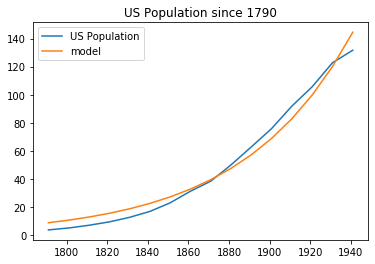

In [28]:
yhat = model1(X,T)
plt.plot(time, data[:,1])
plt.plot(time, yhat)
plt.legend(['US Population', 'model'])
plt.title('US Population since 1790')
plt.show()

In [29]:
#Different model

x0 = np.array([150, .4, -15])
model = lambda x, t: x[0]/(1 + np.exp(-x[1]*(t + x[2])))
T = data[:,0]
y = data[:,1]
residual = lambda x: model(x, T) - y

# Define the Jacobian of the residual function, computed by hand.
jac = lambda x: np.column_stack((1/(1 + np.exp(-x[1]*(T + x[2]))), \
                                 x[0]*(T + x[2])*(1 + np.exp(-x[1]*(T + x[2])))**(-2), \
                                 x[0]*x[1]*(1 + np.exp(-x[1]*(T + x[2])))**(-2)))
                                
                                
X = leastsq(func=residual, x0=x0, Dfun=jac)[0]
print(X)

[175.92019886   0.33629982 -11.72522672]


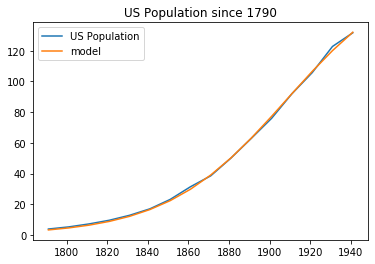

In [30]:
yhat = model(X,T)
plt.plot(time, data[:,1])
plt.plot(time, yhat)
plt.legend(['US Population', 'model'])
plt.title('US Population since 1790')
plt.show()